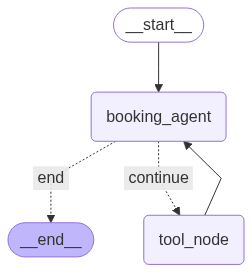

In [21]:
from typing import TypedDict, Annotated, Sequence, Dict, Any
from langchain_core.messages import BaseMessage, ToolMessage, SystemMessage, AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import tool
from IPython.display import Image, display
from langchain_core.tools import StructuredTool
from llm.llm import llm
from llm.context_manager import trim_messages
from tools.create_booking_tool import create_and_save_booking
from tools.read_slots_tool import check_availability_and_suggest_slot
from tools.update_booking_tool import update_booking_status
import os

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    messages: Annotated[Sequence[BaseMessage], add_messages]
    current_tool: str | None
    tool_input: Dict[str, Any] | None
    
tools = [
    StructuredTool.from_function(
        func=create_and_save_booking,
        name="create_booking",
        description="Creates a new booking appointment",
        args_schema={
            "user_id": (str, "ID of the user making the booking"),
            "description": (str, "Description of the booking"),
            "parsed_time": (str, "ISO format datetime string")
        },
        return_type=str
    ),
    StructuredTool.from_function(
        func=check_availability_and_suggest_slot,
        name="check_availability",
        description="Checks if a time slot is available",
        args_schema={
            "provider_id": (str, "ID of the service provider"),
            "requested_time": (str, "ISO format datetime string")
        },
        return_type=ToolMessage
    ),
    StructuredTool.from_function(
        func=update_booking_status,
        name="update_booking",
        description="Updates an existing booking's status",
        args_schema={
            "booking_id": (str, "ID of the booking to update"),
            "status": (str, "New status for the booking"),
            "new_time": (str, "Optional new time for rescheduling"),
            "reason": (str, "Optional reason for update")
        },
        return_type=ToolMessage
    )
]

model = llm.bind_tools(tools=tools)
tool_executor = ToolNode(tools=tools)


async def booking_agent(state: AgentState) -> AgentState:
    """
    Booking agent that handles appointment scheduling and management.
    """
    # System message with detailed booking capabilities
    system_message = SystemMessage(content="""You are an intelligent booking assistant designed to help users schedule and manage appointments efficiently. 

    Tools available:
    1. create_booking(user_id: str, description: str, parsed_time: str) -> Creates new bookings
    2. check_availability(provider_id: str, requested_time: datetime) -> Checks slot availability
    3. update_booking(booking_id: str, status: str, new_time: Optional[datetime], reason: Optional[str]) -> Updates bookings

    Process Steps:
    1. For new bookings:
      - Ask for preferred date/time
      - Use check_availability to verify slot
      - Get user_id and description
      - Confirm all details with user
      - Use create_booking to finalize

    2. For updates:
      - Get booking_id from user
      - For rescheduling: check_availability first
      - Use update_booking with appropriate status
      - Confirm changes with user

    Validation Rules:
      - Description must be 10-500 characters
      - Times must be in ISO format
      - Valid statuses: PENDING, CONFIRMED, CANCELLED, RESCHEDULED

    Always:
      - Be concise and clear
      - Proactively check for conflicts
      - Suggest alternatives for unavailable slots
      - Confirm all actions before execution
      """)

    # Trim messages to fit context window
    state["messages"] = trim_messages(state["messages"], max_tokens=4000)
  
    # Initial greeting for new conversations
    if not state["messages"]:
        return {"messages": [
            system_message,
            AIMessage(content="Hello! I'm your booking assistant. How may I assist you today?")
        ]}

    # Prepare conversation history
    all_messages = [system_message] + list(state["messages"])
    
    # Get model response
    response = await model.invoke(all_messages)

    # Handle tool calls
    if hasattr(response, "tool_calls") and response.tool_calls:
        tool_names = [tc.name for tc in response.tool_calls]
        print(f"🔧 Using tools: {', '.join(tool_names)}")
        
        # Execute tools and get results
        tool_results = []
        for tool_call in response.tool_calls:
            if tool_call.name in tools:
                result = await tools[tool_call.name].ainvoke(tool_call.args)
                print("Tool args:", tool_call.args)
                tool_results.append(ToolMessage(
                    tool_call_id=tool_call.id,
                    content=str(result)
                ))

        # Add tool results to conversation
        return {"messages": list(state["messages"]) + [response] + tool_results}

    # Return updated conversation state
    return {"messages": list(state["messages"]) + [response]}

def should_continue(state: AgentState) -> str:
    """
    Check if we should end the conversation based on booking completion or user request.
    
    Returns:
        str: "continue" to keep conversation going, "end" to terminate
    """
    messages = state["messages"]
    if not messages:
        return "continue"
    
    # Check the most recent messages
    for message in reversed(messages):
        # End if booking was successfully created
        if (isinstance(message, ToolMessage) and
            any(success_indicator in message.content.lower() 
                for success_indicator in ["booking confirmed", "successfully saved", "booking id"])
           ):
            return "end"
        
        # End if booking was cancelled/rescheduled
        if (isinstance(message, ToolMessage) and
            any(update_indicator in message.content.lower()
                for update_indicator in ["cancelled", "rescheduled", "updated to"])
           ):
            return "end"
        
        # End if user explicitly wants to end
        if (isinstance(message, HumanMessage) and
            any(exit_phrase in message.content.lower()
                for exit_phrase in ["goodbye", "thank you", "that's all", "exit"])
           ):
            return "end"
    
    return "continue"

graph_builder = StateGraph(AgentState)
graph_builder.add_node("booking_agent", booking_agent)
graph_builder.add_node("tool_node", tool_executor)
graph_builder.add_edge(START, "booking_agent")

graph_builder.add_conditional_edges(
    "booking_agent",
    should_continue,
    {
        "continue": "tool_node",
        "end": END
    }
)
graph_builder.add_edge("tool_node", "booking_agent")

graph = graph_builder.compile(checkpointer=MemorySaver())

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            msg = value["messages"][-1]
            if isinstance(msg, AIMessage):
                print("Assistant:", msg.content)
            elif isinstance(msg, ToolMessage):
                print("🔧 Tool Response:", msg.content)